In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import glob

In [7]:
# Grab only sorted uncolored filenames
fnames = sorted(glob.glob('../humans/data_ours/*uncolored_sorted*.csv'))
print('There are', len(fnames), 'participants.')

def process(df):
    relevant_cols = [
        'Participant #', 
        'current_problem_num', 
        'accuracy', 
        'trials.thisTrialN',
        'expName'
    ]
    df = df[relevant_cols]

    # Rename for consistency
    df = df.rename(columns = {'Participant #': 'participant', 'current_problem_num': 'problem', 'trials.thisTrialN': 'raw_trials'})

    # No nulls
    df = df[df['problem'].notnull()]

    # Count all trials
    df = df.groupby(['problem','participant']).raw_trials.count().to_frame().reset_index()

    # Trial counts are not trials to criterion yet (need to subtract 7, unless fail)
    df['trials_to_criterion'] = [34 if raw_trial == 34 else raw_trial - 7 for raw_trial in df.raw_trials]

    df = df.drop(columns = ['raw_trials'])

    # New column source
    df['agent'] = 'Humans'

    return df

# Calculate dependent variable for each participant 
human_data = pd.DataFrame()
for fname in fnames:
    df = pd.read_csv(fname)
    human_data = pd.concat([human_data, process(df)], ignore_index=True)
display(human_data)

There are 34 participants.


,problem,participant,trials_to_criterion,agent
0,1.0,100,0,Humans
1,2.0,100,10,Humans
2,3.0,100,34,Humans
3,4.0,100,13,Humans
4,5.0,100,24,Humans
...,...,...,...,...
777,19.0,96,4,Humans
778,20.0,96,12,Humans
779,21.0,96,7,Humans
780,22.0,96,0,Humans


In [10]:
# gpt-4o results
gpt_4o = pd.read_csv('../gpt-4o/interactive/results/23_limited_results.csv')
gpt_4o['agent'] = 'gpt-4o'

# gpt-4-vision-preview
gpt_4_vision_preview = pd.read_csv('../gpt-4-vision-preview/interactive/results/23_limited_results.csv')
gpt_4_vision_preview['agent'] = 'gpt-4-vision-preview'

gpt = pd.concat([gpt_4o, gpt_4_vision_preview])

#
final_results = gpt.groupby(['problem','agent']).trial.count().to_frame().reset_index()
final_results = final_results.rename(columns = {'trial': 'raw_trials'})
final_results['trials_to_criterion'] = [34 if raw_trial == 34 else raw_trial - 7 for raw_trial in final_results.raw_trials]

# Concat both files
final_results = pd.concat([final_results, human_data])
final_results = final_results.sort_values('agent')

# Problem column is integer
final_results['problem'] = final_results['problem'].astype(int)

# Define fails
final_results['fails'] = [1 if ttc == 34 else 0 for ttc in final_results.trials_to_criterion]
final_results['event'] = [0 if ttc == 34 else 1 for ttc in final_results.trials_to_criterion]

display(final_results)

,problem,agent,raw_trials,trials_to_criterion,participant,fails,event
367,23,Humans,NaN,7,28.0,0,1
500,18,Humans,NaN,0,4.0,0,1
501,19,Humans,NaN,1,4.0,0,1
502,20,Humans,NaN,6,4.0,0,1
503,21,Humans,NaN,34,4.0,1,0
...,...,...,...,...,...,...,...
19,10,gpt-4o,34.0,34,NaN,1,0
35,18,gpt-4o,34.0,34,NaN,1,0
21,11,gpt-4o,15.0,8,NaN,0,1
23,12,gpt-4o,34.0,34,NaN,1,0


In [11]:
def get_num_objects(problem):
    dict_num_objects = {
        1: 2,
        2: 2,
        3: 4,
        4: 2,
        5: 4,
        6: 4,
        7: 6, 
        8: 2,
        9: 3,
        10: 4,
        11: 2,
        12: 3,
        13: 4,
        14: 3,
        15: 4,
        16: 6,
        17: 4,
        18: 6,
        19: 2,
        20: 2,
        21: 2,
        22: 3,
        23: 3
    }
    return dict_num_objects[problem]

final_results['num_objects'] = [get_num_objects(problem) for problem in final_results.problem]
final_results.head()

,problem,agent,raw_trials,trials_to_criterion,participant,fails,event,num_objects
367,23,Humans,NaN,7,28.0,0,1,3
500,18,Humans,NaN,0,4.0,0,1,6
501,19,Humans,NaN,1,4.0,0,1,2
502,20,Humans,NaN,6,4.0,0,1,2
503,21,Humans,NaN,34,4.0,1,0,2


In [12]:
# Save results
final_results.to_csv('results/svrt_limited_allagents.csv')

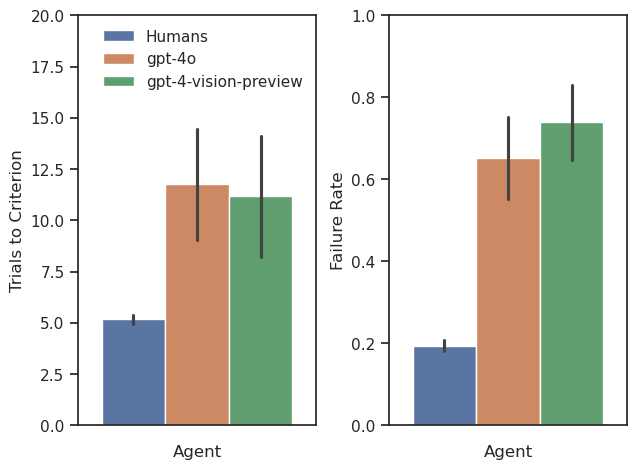

In [33]:
# Overall

# Define your custom order for the 'agent' column
custom_order = ['Humans', 'gpt-4o', 'gpt-4-vision-preview']
order_mapping = {agent: idx for idx, agent in enumerate(custom_order)}
final_results['agent_order'] = final_results['agent'].map(order_mapping)
final_results = final_results.sort_values('agent_order')

# Define a function to use for custom error bars
def standard_error_proportion(group):
    count = group.sum()
    nobs = len(group)
    p = count / nobs
    sep = np.sqrt(p * (1 - p) / nobs)
    return p - sep, p + sep

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6.4, 4.8))
sns.set_context('notebook')
sns.set_style("white")
sns.set_palette('deep')
plt.tight_layout()

sns.barplot(
    data=final_results[final_results.trials_to_criterion != 34],
    hue = 'agent',
    y='trials_to_criterion',
    errorbar = 'se',
    ax = ax[0],
    palette = 'deep'
).set(
    ylabel = 'Trials to Criterion',
    xlabel = 'Agent',
    ylim = (0, 20)
)
ax[0].legend().get_frame().set_linewidth(0.0)

sns.barplot(
    data = final_results,
    hue = 'agent',
    y = 'fails',
    errorbar = lambda x: standard_error_proportion(x),
    ax = ax[1],
    palette = 'deep'
).set(
    ylabel = 'Failure Rate',
    xlabel = 'Agent',
    ylim = (0,1),
)
ax[1].legend().remove()

for a in ax:
    a.yaxis.set_ticks_position('left')

Humans
             CIF_1
event_at          
0.0       0.000000
1.0       0.095908
2.0       0.179028
3.0       0.251918
4.0       0.310742
5.0       0.361893
6.0       0.411765
7.0       0.468031
8.0       0.497442
9.0       0.508951
10.0      0.526854
11.0      0.547315
12.0      0.560102
13.0      0.571611
14.0      0.584399
15.0      0.589514
16.0      0.597187
17.0      0.613811
18.0      0.621483
19.0      0.629156
20.0      0.638107
21.0      0.639386
22.0      0.640665
23.0      0.641944
24.0      0.644501
25.0      0.652174
34.0      0.652174
gpt-4o
             CIF_1
event_at          
0.0       0.000000
1.0       0.086957
8.0       0.130435
13.0      0.173913
15.0      0.217391
17.0      0.260870
18.0      0.304348
21.0      0.347826
34.0      0.347826
gpt-4-vision-preview
             CIF_1
event_at          
0.0       0.000000
1.0       0.043478
5.0       0.086957
10.0      0.130435
15.0      0.173913
16.0      0.217391
20.0      0.260870
34.0      0.260870


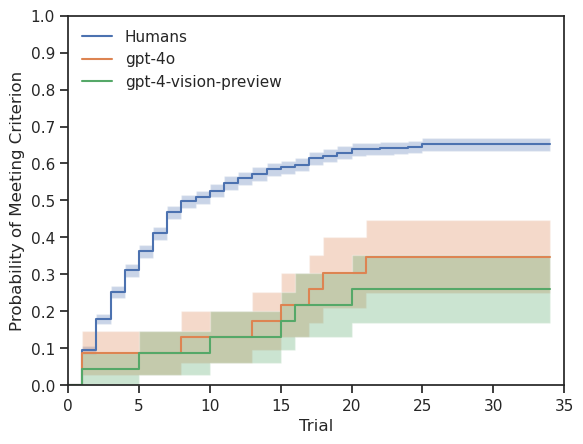

In [23]:
# This approach accounts for informative censoring (meaning that prob of problem fail/censor increases with trials to criterion)

from lifelines import AalenJohansenFitter

# Define events: 1 if criterion met, 2 if censored at 34 trials
survival_results = final_results.copy(deep=True)

# Assuming survival_results DataFrame is already defined
fig, ax = plt.subplots()
sns.set_context('notebook')
sns.set_style("white")
sns.set_palette('deep')
# plt.tight_layout()

for agent in survival_results['agent'].unique():
    mask = survival_results['agent'] == agent
    aj = AalenJohansenFitter()
    aj.fit(
        durations=survival_results[mask]['trials_to_criterion'], 
        event_observed=survival_results[mask]['event'], 
        event_of_interest=1
    )
    
    # Extract cumulative incidence function data
    print(f"{agent}")
    cumulative_incidence_data = aj.cumulative_density_
    print(cumulative_incidence_data)

    # Calculate the binomial standard error
    n = survival_results[mask].shape[0]
    se = np.sqrt(cumulative_incidence_data['CIF_1'] * (1 - cumulative_incidence_data['CIF_1']) / n)

    # Plot the CIF curve as a step function
    plt.step(cumulative_incidence_data.index, cumulative_incidence_data['CIF_1'], where='post', label=f"{agent}")
    
    # Plot the binomial SE bands as a step function
    plt.fill_between(cumulative_incidence_data.index,
                     cumulative_incidence_data['CIF_1'] - se,
                     cumulative_incidence_data['CIF_1'] + se,
                     step='post', alpha=0.3)

plt.xlabel('Trial')
plt.ylabel('Probability of Meeting Criterion')
plt.legend(loc='upper left').get_frame().set_linewidth(0.0)

plt.ylim(0, 1)
plt.xlim(0, 35)
plt.yticks(np.arange(0, 1.1, 0.1))

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

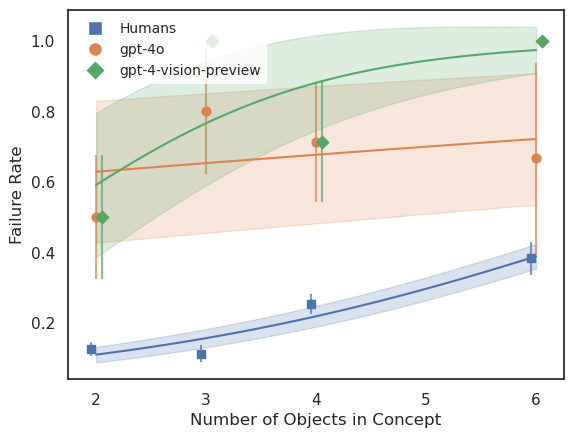

In [35]:
# Failure rate by number of objects

import statsmodels.api as sm
from matplotlib.lines import Line2D

# Function to calculate mean accuracy and binomial confidence intervals
def summarize_data(df):
    summary = df.groupby(['num_objects', 'agent']).agg(
        failure_rate=('fails', 'mean'),
        count=('fails', 'size')
    ).reset_index()

    # Calculate standard error for binomial distribution
    summary['standard_error'] = np.sqrt(summary['failure_rate'] * (1 - summary['failure_rate']) / summary['count'])
    
    return summary

# Calculate summarized data
summary = summarize_data(final_results)

# Plotting
plt.figure(figsize = (6.4, 4.8))
sns.set_context('notebook')

# Unique agents and their properties
agents = ['Humans', 'gpt-4o', 'gpt-4-vision-preview']
num_agents = len(agents)
colors = sns.color_palette('deep')[:num_agents]
markers = ['s', 'o', 'D', '^', 'v']
offsets = np.linspace(-0.05, 0.05, num_agents)  # Offsets to separate error bars

# Custom legend handles
handles = []
    
for agent, color, marker, offset in zip(agents, colors, markers, offsets):

    # Subset summary for the agent
    subset = summary[summary.agent == agent]
    
    # Apply offset to num_objects for plotting both points and error bars
    adjusted_x = subset['num_objects'] + offset
    
    # Plot points with offset
    plt.scatter(adjusted_x, subset['failure_rate'], color=color, marker=marker, zorder=3, s=40)
    
    # Fit logistic regression manually
    X = sm.add_constant(subset['num_objects'])
    y = subset['failure_rate']
    logit_model = sm.Logit(y, X).fit(disp=False)
    
    # Generate predictions and standard errors
    x_pred = np.linspace(subset['num_objects'].min(), subset['num_objects'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = logit_model.predict(X_pred)
    
    # Calculate standard errors based on logistic regression prediction
    se = np.sqrt(y_pred * (1 - y_pred) / subset['count'].mean())  # Adjust SE calculation dynamically
    
    # Plot logistic regression line (smooth)
    plt.plot(x_pred, y_pred, color=color, zorder=2)
    # plt.ylim( (0.4, 1))
    # plt.yticks( np.arange(0.4, 1.05, 0.05))
    
    # Plot standard error bands (smooth)
    plt.fill_between(x_pred, y_pred - se, y_pred + se, color=color, alpha=0.2, zorder=1)
    
    # Plot error bars with the same offset and specified capsize
    plt.errorbar(adjusted_x, subset['failure_rate'], 
                 yerr=subset['standard_error'], 
                 fmt='none', ecolor=color, alpha=0.7, zorder=1, label='_no_legend_')
    
    # Create custom legend handle
    handles.append(Line2D([0], [0], marker=marker, color='w', label=agent,
                          markerfacecolor=color, markersize=10))

plt.xlabel('Number of Objects in Concept')
plt.ylabel('Failure Rate')
plt.legend(handles = handles, loc='upper left', fontsize='small').get_frame().set_linewidth(0.0)
plt.show()

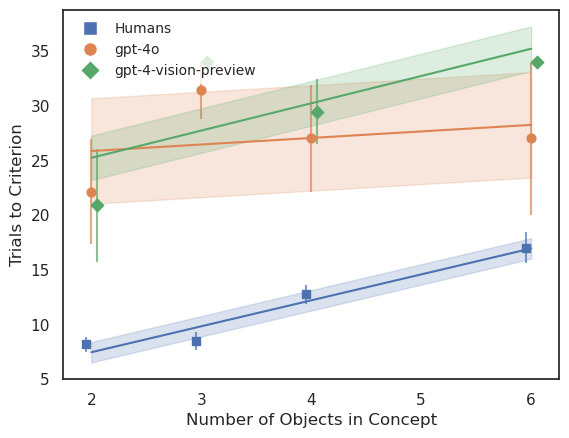

In [36]:
# Failure rate by number of objects

import statsmodels.api as sm
from matplotlib.lines import Line2D

# Function to calculate mean accuracy and standard error
def summarize_data(df):
    summary = df.groupby(['num_objects', 'agent']).agg(
        mean_ttc=('trials_to_criterion', 'mean'),
        count=('trials_to_criterion', 'size'),
        std_dev=('trials_to_criterion', 'std')
    ).reset_index()

    # Calculate standard error for the mean
    summary['standard_error'] = summary['std_dev'] / np.sqrt(summary['count'])
    
    return summary

# Calculate summarized data
summary = summarize_data(final_results)

# Plotting
plt.figure(figsize = (6.4, 4.8))
sns.set_context('notebook')

# Unique agents and their properties
agents = ['Humans', 'gpt-4o', 'gpt-4-vision-preview']
num_agents = len(agents)
colors = sns.color_palette('deep')[:num_agents]
markers = ['s', 'o', 'D', '^', 'v']
offsets = np.linspace(-0.05, 0.05, num_agents)  # Offsets to separate error bars

# Custom legend handles
handles = []
    
for agent, color, marker, offset in zip(agents, colors, markers, offsets):

    # Subset summary for the agent
    subset = summary[summary.agent == agent]
    
    # Apply offset to num_objects for plotting both points and error bars
    adjusted_x = subset['num_objects'] + offset
    
    # Plot points with offset
    plt.scatter(adjusted_x, subset['mean_ttc'], color=color, marker=marker, zorder=3, s=40)
    
    # Fit linear regression
    X = sm.add_constant(subset['num_objects'])
    y = subset['mean_ttc']
    lm_model = sm.OLS(y, X).fit(disp=False)
    
    # Generate predictions
    x_pred = np.linspace(subset['num_objects'].min(), subset['num_objects'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = lm_model.predict(X_pred)
    
    # Plot linear regression line
    plt.plot(x_pred, y_pred, color=color, zorder=2)
    
    # Plot standard error bands
    plt.fill_between(x_pred, y_pred - subset['standard_error'].mean(), y_pred + subset['standard_error'].mean(), color=color, alpha=0.2, zorder=1)
    
    # Plot error bars with the same offset and specified capsize
    plt.errorbar(adjusted_x, subset['mean_ttc'], 
                 yerr=subset['standard_error'], 
                 fmt='none', ecolor=color, alpha=0.7, zorder=1, label='_no_legend_')
    
    # Create custom legend handle
    handles.append(Line2D([0], [0], marker=marker, color='w', label=agent,
                          markerfacecolor=color, markersize=10))

plt.xlabel('Number of Objects in Concept')
plt.ylabel('Trials to Criterion')
plt.legend(handles=handles, loc='upper left', fontsize='small').get_frame().set_linewidth(0.0)
plt.show()

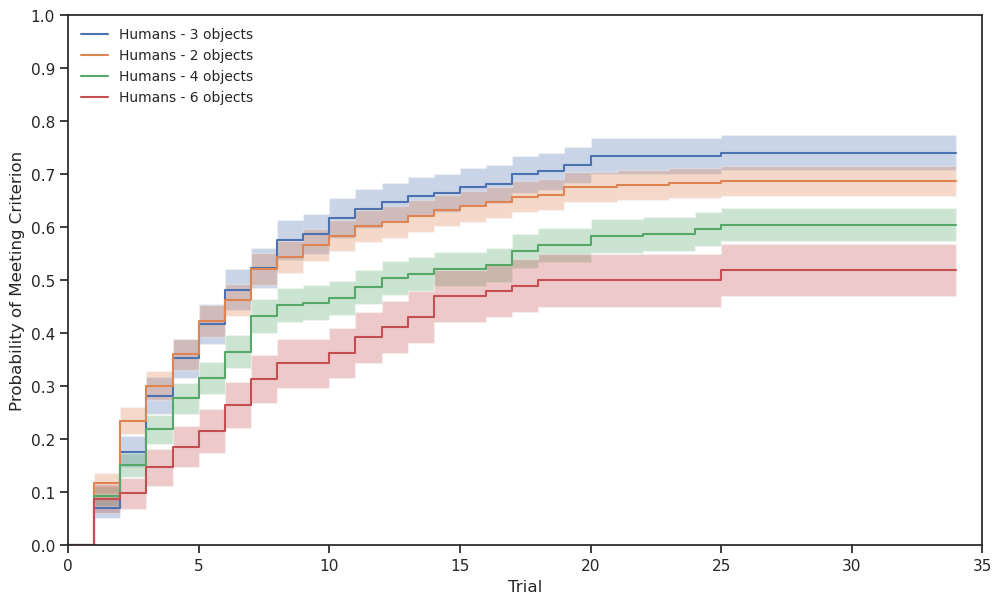

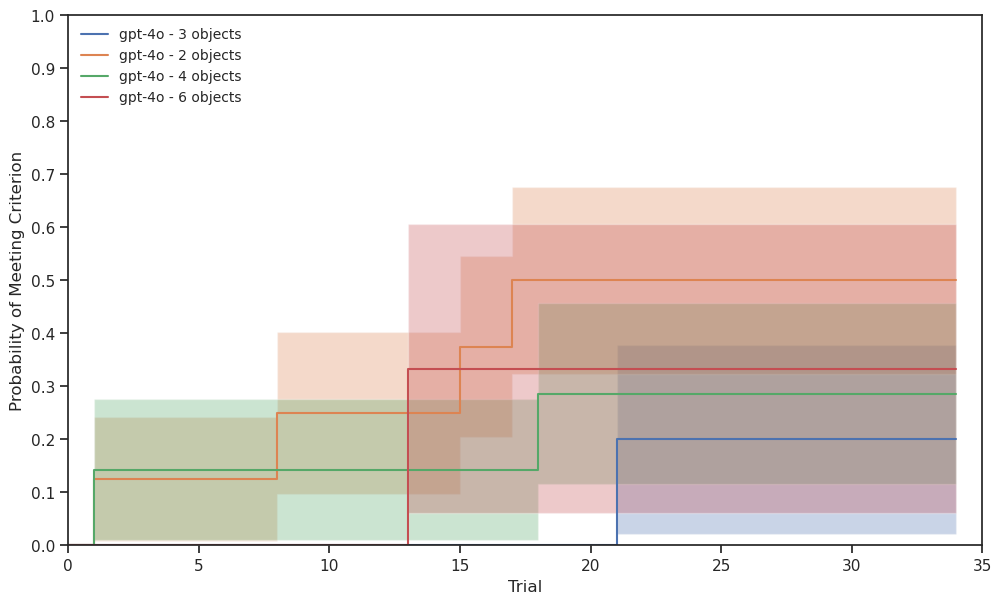

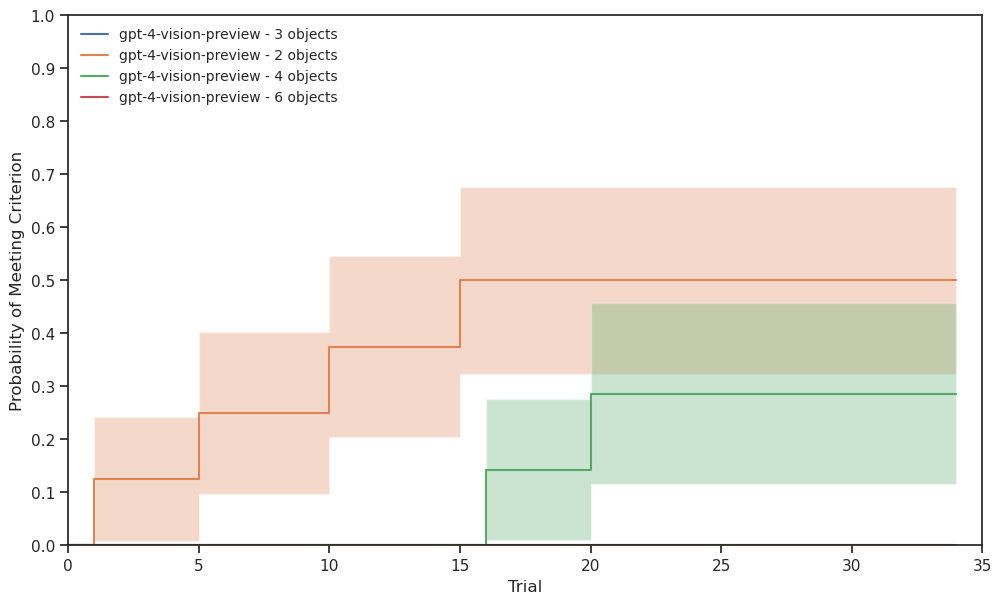

In [32]:
# Iterate over unique combinations of agent and num_objects
for agent in survival_results['agent'].unique():

    # Assuming survival_results DataFrame is already defined
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_context('notebook')
    sns.set_style("white")
    sns.set_palette('deep')

    # Adjust the tight layout to account for multiple subplots
    plt.tight_layout()

    for num_objects in survival_results['num_objects'].unique():
        mask = (survival_results['agent'] == agent) & (survival_results['num_objects'] == num_objects)
        aj = AalenJohansenFitter()
        aj.fit(
            durations=survival_results[mask]['trials_to_criterion'], 
            event_observed=survival_results[mask]['event'], 
            event_of_interest=1
        )
        
        # Extract cumulative incidence function data
        cumulative_incidence_data = aj.cumulative_density_
        
        # Calculate the binomial standard error
        n = survival_results[mask].shape[0]
        se = np.sqrt(cumulative_incidence_data['CIF_1'] * (1 - cumulative_incidence_data['CIF_1']) / n)

        # Plot the CIF curve as a step function
        label = f"{agent} - {num_objects} objects"
        plt.step(cumulative_incidence_data.index, cumulative_incidence_data['CIF_1'], where='post', label=label)
        
        # Plot the binomial SE bands as a step function
        plt.fill_between(cumulative_incidence_data.index,
                            cumulative_incidence_data['CIF_1'] - se,
                            cumulative_incidence_data['CIF_1'] + se,
                            step='post', alpha=0.3)

    plt.xlabel('Trial')
    plt.ylabel('Probability of Meeting Criterion')
    plt.legend(loc='upper left', fontsize='small').get_frame().set_linewidth(0.0)

    plt.ylim(0, 1)
    plt.xlim(0, 35)
    plt.yticks(np.arange(0, 1.1, 0.1))

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.show()

## Misc.

<Figure size 640x480 with 0 Axes>

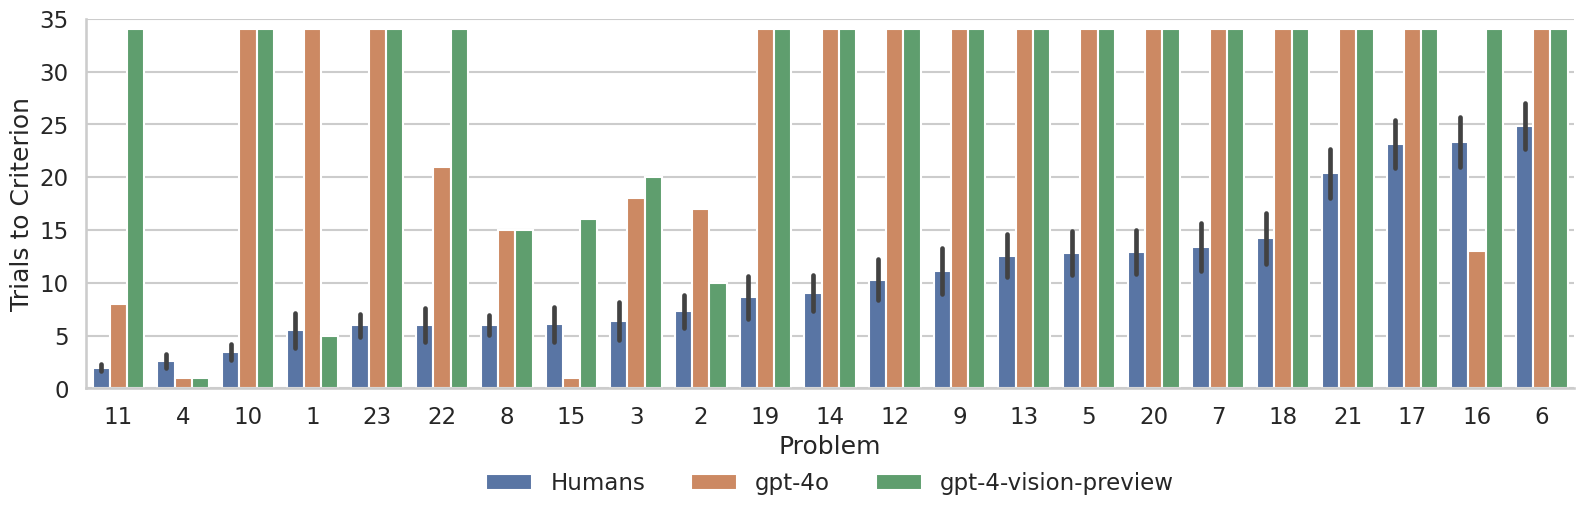

In [15]:
# Order of problem difficulty based on problem means calculated WITH participant fails
my_problem_means = human_data.groupby(['problem']).trials_to_criterion.mean().to_frame().reset_index()
order_problem_means_with_fails = my_problem_means.sort_values('trials_to_criterion').problem.astype(int).to_list()


# Define your custom order for the 'source' column
custom_order = ['Humans', 'gpt-4o', 'gpt-4-vision-preview']
order_mapping = {agent: idx for idx, agent in enumerate(custom_order)}
final_results['agent_order'] = final_results['agent'].map(order_mapping)
final_results = final_results.sort_values('agent_order')

#
sns.set_context('talk')
sns.set_style("whitegrid")
plt.tight_layout()

# Plot
plt.figure(figsize = (6.4*3, 4.8))
sns.barplot(
    data = final_results,
    x = 'problem',
    y = 'trials_to_criterion',
    hue = 'agent',
    errorbar = 'se',
    order = order_problem_means_with_fails,
    palette = 'deep'
).set(
    xlabel = 'Problem',
    ylabel = 'Trials to Criterion',
    ylim = (0,35),
    title = ''
)
plt.legend(bbox_to_anchor=(0.5, -0.17), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)
sns.despine()

<Figure size 640x480 with 0 Axes>

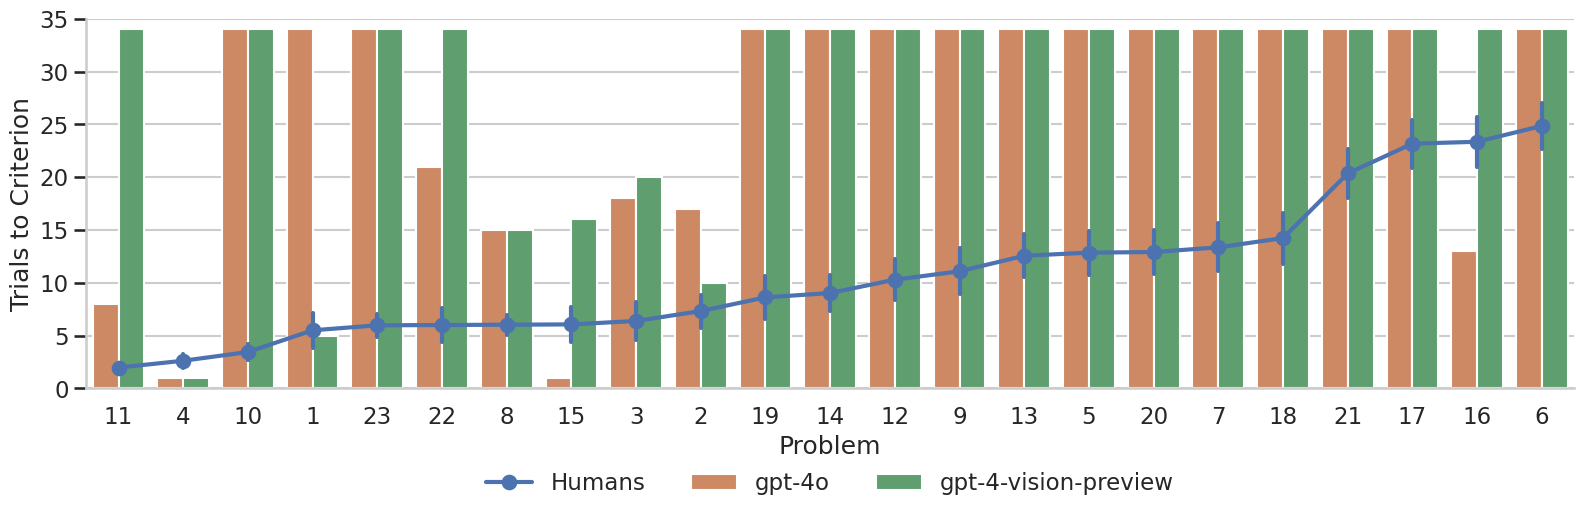

In [10]:
# Order of problem difficulty based on problem means calculated WITH participant fails
my_problem_means = human_data.groupby(['problem']).trials_to_criterion.mean().to_frame().reset_index()
order_problem_means_with_fails = my_problem_means.sort_values('trials_to_criterion').problem.astype(int).to_list()

# Define your custom order for the 'source' column
custom_order = ['Humans', 'gpt-4o', 'gpt-4-vision-preview']
order_mapping = {source: idx for idx, source in enumerate(custom_order)}
final_results['source_order'] = final_results['source'].map(order_mapping)
final_results = final_results.sort_values('source_order')

# Separate human and model data
human_data = final_results[final_results['source'] == 'Humans']
model_data = final_results[final_results['source'] != 'Humans']

# Plot settings
sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette('deep')
plt.tight_layout()

# Create the plot
fig, ax = plt.subplots(figsize=(6.4*3, 4.8))

# Pointplot for model data
sns.barplot(
    data=model_data,
    x='problem',
    y='trials_to_criterion',
    hue='source',
    order=order_problem_means_with_fails,
    palette = sns.color_palette('deep')[1:3],
    errorbar='se',
)

# Barplot for human data
sns.pointplot(
    data=human_data,
    x='problem',
    y='trials_to_criterion',
    order=order_problem_means_with_fails,
    errorbar = 'se',
    label='Humans',
    markersize = 9,
    lw = 3
)

# Customize the plot
plt.xlabel('Problem')
plt.ylabel('Trials to Criterion')
plt.ylim(0, 35)

# Adjust legend to show humans first
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index('Humans'), labels.index('gpt-4o'), labels.index('gpt-4-vision-preview')]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
plt.legend(handles, labels, bbox_to_anchor=(0.5, -0.17), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)

ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

sns.despine()

plt.show()

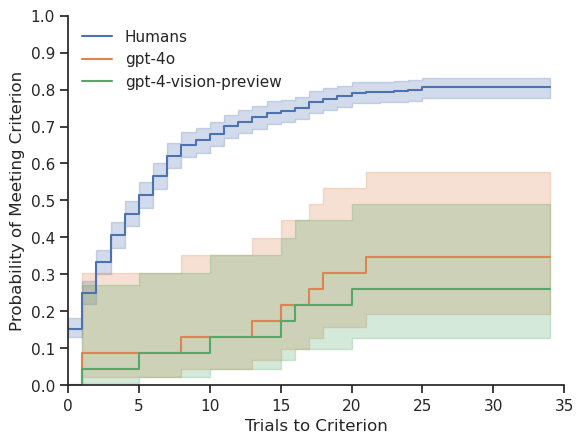

In [68]:
# This approach does NOT account for informative censoring (meaning that prob of problem fail/censor increases with trials to criterion)

from lifelines import KaplanMeierFitter

# Fit the Kaplan-Meier estimator and plot for each source
fig, ax = plt.subplots()
for source in survival_results['source'].unique():
    mask = survival_results['source'] == source
    kmf = KaplanMeierFitter()
    # Recode events for Kaplan-Meier (event of interest as 1, others as 0)
    kmf.fit(
        durations=survival_results[mask]['trials_to_criterion'], 
        event_observed=(survival_results[mask]['event'] == 1), 
        label=f"Kaplan-Meier for {source}")
    kmf.plot_cumulative_density(ax=plt.gca(), label=f"{source}")

plt.xlabel('Trials to Criterion')
plt.ylabel('Probability of Meeting Criterion')
plt.legend(loc = 'upper left').get_frame().set_linewidth(0.0)

plt.ylim(0,1)
plt.xlim(0,35)
plt.yticks(np.arange(0, 1.1, 0.1))

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
sns.despine()

<Figure size 640x480 with 0 Axes>

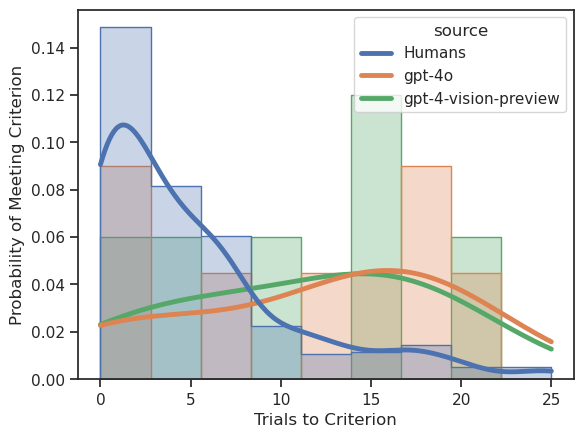

In [270]:
# Remove fails
final_results_wo_fails = final_results[final_results.trials_to_criterion != 34]

# Plot
sns.set_context('notebook')
sns.set_style("white")
plt.tight_layout()
fig, ax = plt.subplots(1,1)
sns.histplot(
    data = final_results_wo_fails,
    x = 'trials_to_criterion',
    hue = 'source',
    element = 'step',
    stat = 'density',
    common_norm=False,
    # multiple = 'stack', # puts histograms on top of each other, so don't use
    palette = 'deep',
    # fill = False,
    linewidth = 1,
    alpha = 0.3,
    bins = 9,
    ax = ax
).set(
    xlabel = 'Trials to Criterion',
    ylabel = 'Probability of Meeting Criterion',
    title = '',
)
sns.kdeplot(
    data=final_results_wo_fails, 
    x='trials_to_criterion', 
    hue='source',
    common_norm=False, 
    palette='deep', 
    linewidth = 3.5, 
    clip = (0, 25),
    ax = ax
)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# handles, labels = ax.get_legend_handles_labels()
# new_labels = ['gpt-4o', 'Humans']
# ax.legend(handles, new_labels).get_frame().set_linewidth(0.0)

### Plot of same-different vs. spatial relations

,problem,raw_trials,trials_to_criterion,source,participant,relation_color
3,4,8.0,1,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
14,15,8.0,1,gpt-4o / High Image Detail,NaN,"(0.86, 0.3712, 0.33999999999999997)"
10,11,15.0,8,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
15,16,20.0,13,gpt-4o / High Image Detail,NaN,"(0.86, 0.3712, 0.33999999999999997)"
7,8,22.0,15,gpt-4o / High Image Detail,NaN,"(0.86, 0.33999999999999997, 0.8287999999999999)"
1,2,24.0,17,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
2,3,25.0,18,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
21,22,28.0,21,gpt-4o / High Image Detail,NaN,"(0.86, 0.3712, 0.33999999999999997)"
9,10,34.0,34,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
22,23,34.0,34,gpt-4o / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"


/tmp/ipykernel_1665684/1248446972.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


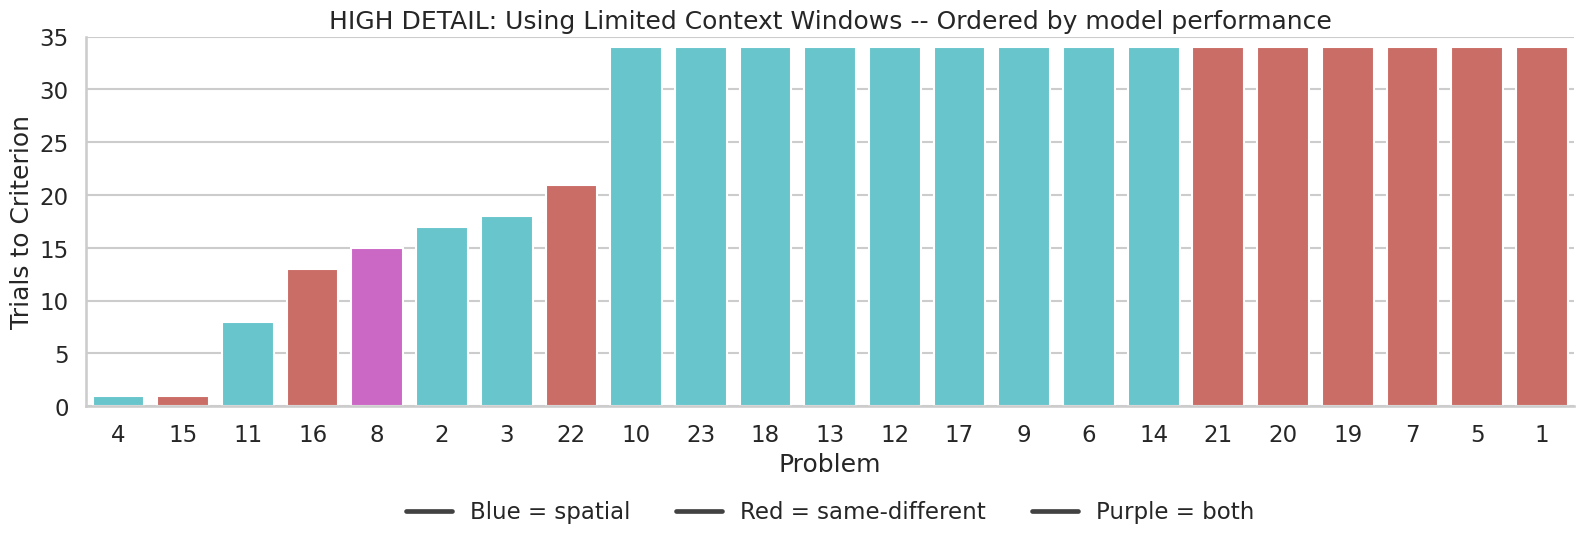

In [10]:
# Just gpt results
results_gpt = final_results[final_results.source == 'gpt-4o / High Image Detail']

# SORT VALUES by trials to criterion
results_gpt = results_gpt.sort_values('trials_to_criterion')

# Order of problem difficulty based on problem means calculated WITH participant fails
order_gpt = results_gpt.problem.to_list()

# Lists of x-ticks for different coloring
same_different = [20,7,21,19,1,22,5,15,16,]  
spatial = [6,17,9,13,23,14,4,12,10,18,3,11,2]
both = [8]

# Create a color list based on membership in the lists above
def assign_color(problem):
    if problem in same_different:
        return (0.86, 0.3712, 0.33999999999999997)  # seaborn hls red
    elif problem in spatial:
        return (0.33999999999999997, 0.8287999999999999, 0.86)  # seaborn hls blue
    elif problem in both:
        return (0.86, 0.33999999999999997, 0.8287999999999999)  # seaborn hls light purple
results_gpt['relation_color'] = [assign_color(problem) for problem in results_gpt['problem']]

# Sort values again 
results_gpt = results_gpt.sort_values(['trials_to_criterion','relation_color'])

display(results_gpt)

# Plot
plt.figure(figsize = (6.4*3, 4.8))
sns.set_context('talk')
sns.set_style("whitegrid")
plt.tight_layout()
sns.barplot(
    data = results_gpt,
    x = 'problem',
    y = 'trials_to_criterion',
    order = results_gpt['problem'],
    palette = results_gpt['relation_color'].to_list()
).set(
    xlabel = 'Problem',
    ylabel = 'Trials to Criterion',
    ylim = (0,35),
    title = 'HIGH DETAIL: Using Limited Context Windows -- Ordered by model performance'
)
plt.legend(labels=['Blue = spatial', 'Red = same-different', 'Purple = both'], bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)
sns.despine()

## Together with low-res limited

In [18]:
base = '/home/andrewlee0/Documents/GPT-4V DALLE-3 NeurIPS 2024/gpt/svrt/limited/results'
oneto5 = pd.read_csv(f'{base}/5_max10images_limited_gpt4v_svrt_performance.csv')
sixto23 = pd.read_csv(f'{base}/23_max10images_limited_gpt4v_svrt_performance.csv')
all_results_low = pd.concat([oneto5, sixto23])
print(all_results.columns)

final_results_low = all_results_low.groupby(['problem']).trial.count().to_frame().reset_index()
final_results_low = final_results_low.rename(columns = {'trial': 'raw_trials'})

# Trial counts are not trials to criterion yet (need to subtract 7, unless fail)
final_results_low['trials_to_criterion'] = [34 if raw_trial == 34 else raw_trial - 7 for raw_trial in final_results_low.raw_trials]

# # Fleuret data sets fails to 35, but this is not comparable to GPT's fails set to 34 (need to change all 35s to 34s)
# fleuret_svrt_data['trials_to_criterion'] = [34 if trials_to_criterion == 35 else trials_to_criterion for trials_to_criterion in fleuret_svrt_data['trials_to_criterion']]

# Add a source column for plotting
final_results_low['source'] = 'gpt-4-vision-preview / Low Image Detail'


# Concat both files
final_final = pd.concat([final_results, final_results_low])

display(final_results)

Index(['Unnamed: 0', 'trial', 'file_path', 'shortened_file_path', 'problem',
       'category', 'exemplar', 'num_calls_to_API', 'raw_response_to_trial',
       'selected_category', 'accuracy', 'correct_in_row', 'feedback',
       'raw_response_to_feedback', 'feedback_response',
       'raw_response_to_next_problem', 'next_problem_response', 'temperature'],
      dtype='object')


,problem,raw_trials,trials_to_criterion,source,participant
218,12,NaN,7,Human Data from Fleuret et al. (2011),10.0
306,8,NaN,1,Human Data from Fleuret et al. (2011),14.0
305,7,NaN,34,Human Data from Fleuret et al. (2011),14.0
304,6,NaN,34,Human Data from Fleuret et al. (2011),14.0
303,5,NaN,1,Human Data from Fleuret et al. (2011),14.0
...,...,...,...,...,...
20,21,34.0,34,gpt-4-vision-preview / High Image Detail,NaN
21,22,34.0,34,gpt-4-vision-preview / High Image Detail,NaN
22,23,34.0,34,gpt-4-vision-preview / High Image Detail,NaN
11,12,34.0,34,gpt-4-vision-preview / High Image Detail,NaN


<Figure size 640x480 with 0 Axes>

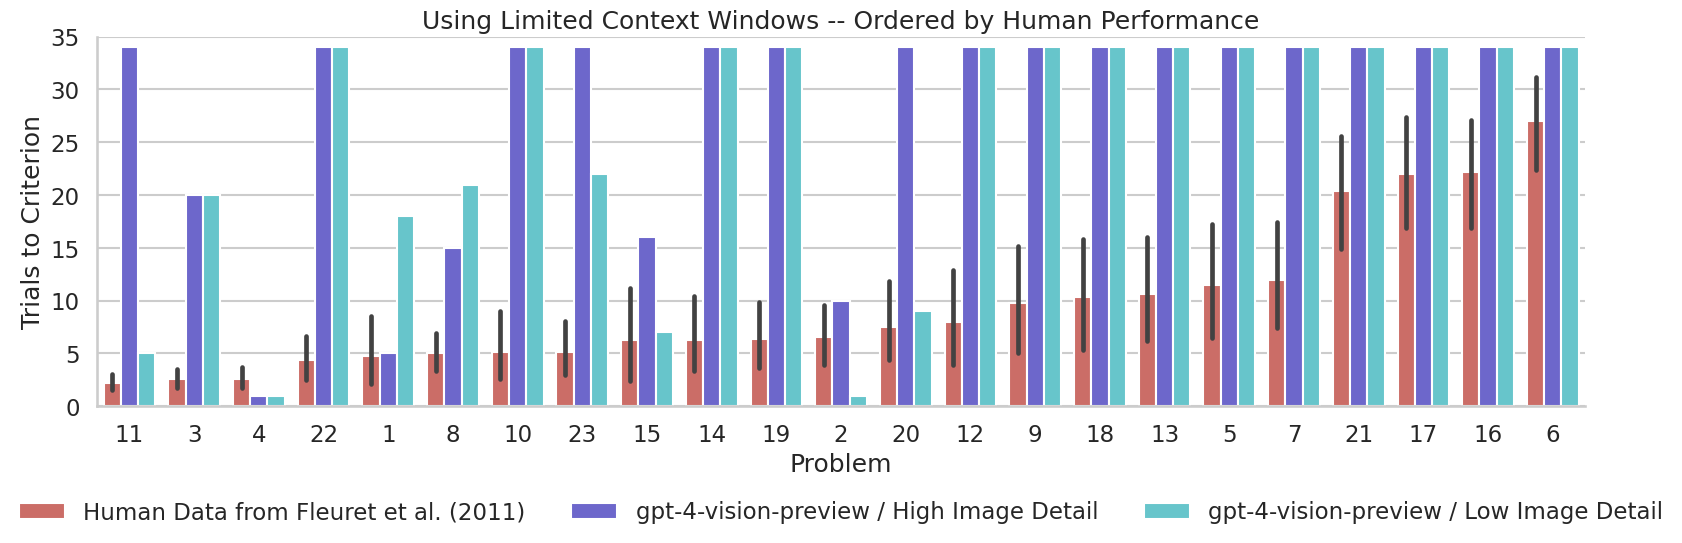

In [26]:
# Order of problem difficulty based on problem means calculated WITH participant fails
my_problem_means = fleuret_svrt_data.groupby(['problem']).trials_to_criterion.mean().to_frame().reset_index()
order_problem_means_with_fails = my_problem_means.sort_values('trials_to_criterion').problem.to_list()

#
sns.set_context('talk')
sns.set_style("whitegrid")
plt.tight_layout()

# Plot
plt.figure(figsize = (6.4*3, 4.8))
sns.barplot(
    data = final_final,
    x = 'problem',
    y = 'trials_to_criterion',
    hue = 'source',
    order = order_problem_means_with_fails,
    palette = [
        sns.hls_palette()[0],
        sns.hls_palette()[4],
        sns.hls_palette()[3]
    ]
).set(
    xlabel = 'Problem',
    ylabel = 'Trials to Criterion',
    ylim = (0,35),
    title = 'Using Limited Context Windows -- Ordered by Human Performance'
)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)
sns.despine()

In [35]:
# T-test
from scipy.stats import ttest_rel

high_detail = final_final[final_final.source == 'gpt-4-vision-preview / High Image Detail'].sort_values('problem')['trials_to_criterion']
low_detail = final_final[final_final.source == 'gpt-4-vision-preview / Low Image Detail'].sort_values('problem')['trials_to_criterion']

high_mean = np.mean(high_detail)
low_mean = np.mean(low_detail)
print(high_mean, low_mean)

print( ttest_rel(high_detail, low_detail))

28.043478260869566 25.217391304347824
TtestResult(statistic=1.5011834863114706, pvalue=0.14752520361790358, df=22)


In [45]:
sns.hls_palette()

[(0.86, 0.3712, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999)]

In [48]:
print(sns.hls_palette()[0]) # red
print(sns.hls_palette()[3]) # light blue
print(sns.hls_palette()[4]) # blue
print(sns.hls_palette()[5]) # light purple

(0.86, 0.3712, 0.33999999999999997)
(0.33999999999999997, 0.8287999999999999, 0.86)
(0.86, 0.33999999999999997, 0.8287999999999999)
